In [1]:
%load_ext autoreload
%autoreload 2

import detectron2
# from detectron2.utils.logger import setup_logger
#
# setup_logger()
import cv2
import pandas as pd
from detectron2.data import MetadataCatalog
import torch
from utils import read_json, get_instance_pretrained_predictor, cv2_imshow, predict_instance_segmentation
import numpy as np
from tqdm import tqdm

In [62]:
mapping = read_json('mapping.json')
color_mapping = mapping['color_mapping']
class_mapping = mapping['class_mapping']
coco_classes = mapping['coco_classes']
cfg, predictor = get_instance_pretrained_predictor()

In [119]:
dataset = 'super-robust'
img_dir = f'../data/{dataset}/rgb/'
gt_dir = f'../data/{dataset}/semantic/'
acc = {c: [] for c in color_mapping}
for img_idx in tqdm(range(5600)):
# read image and convert to rgb
    im = cv2.imread(f'{img_dir}/{img_idx:06}.png')[:, :, ::-1]
    gt = cv2.imread(f'{gt_dir}/{img_idx:06}.png')[:, :, ::-1]


    # predictor takes BGR value
    output = predictor(im[:, :, ::-1])
    instances = set([class_mapping[coco_classes[i]] for i in output['instances'].pred_classes.cpu() if
                 coco_classes[i] in class_mapping])

    for name, color in color_mapping.items():
        # check if a pixel represent the class exists
        type_exists = np.all(gt == color, axis=2).any()
        if type_exists == (name in instances):
            acc[name].append(1)
        else:
            acc[name].append(0)


  0%|          | 0/5600 [00:00<?, ?it/s]c:\users\chenp\documents\github\detectron2\detectron2\structures\image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
100%|██████████| 5600/5600 [15:00<00:00,  6.22it/s]


In [120]:
for t in acc:
    print(t)
    print(sum(acc[t]) / len(acc[t]))

pedestrian
0.7628571428571429
vehicle
0.9996428571428572
traffic light
0.5807142857142857


In [121]:
acc_df = pd.DataFrame(acc)
acc_df.to_csv(f'{dataset}.csv', index=None)

c:\users\chenp\documents\github\detectron2\detectron2\structures\image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


Instances(num_instances=6, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 213.0963,  343.6478,  580.9387,  502.6697],
        [ 562.6412,  229.8236,  575.0516,  262.4233],
        [1054.6841,  356.1153, 1170.2299,  414.0660],
        [ 370.5907,  362.0912,  403.8301,  389.2747],
        [ 915.5984,  228.4812,  927.7779,  259.7765],
        [1054.8418,  356.4315, 1170.4452,  413.6982]], device='cuda:0')), scores: tensor([0.9934, 0.9607, 0.9248, 0.9004, 0.7341, 0.5556], device='cuda:0'), pred_classes: tensor([2, 9, 2, 0, 9, 7], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False,

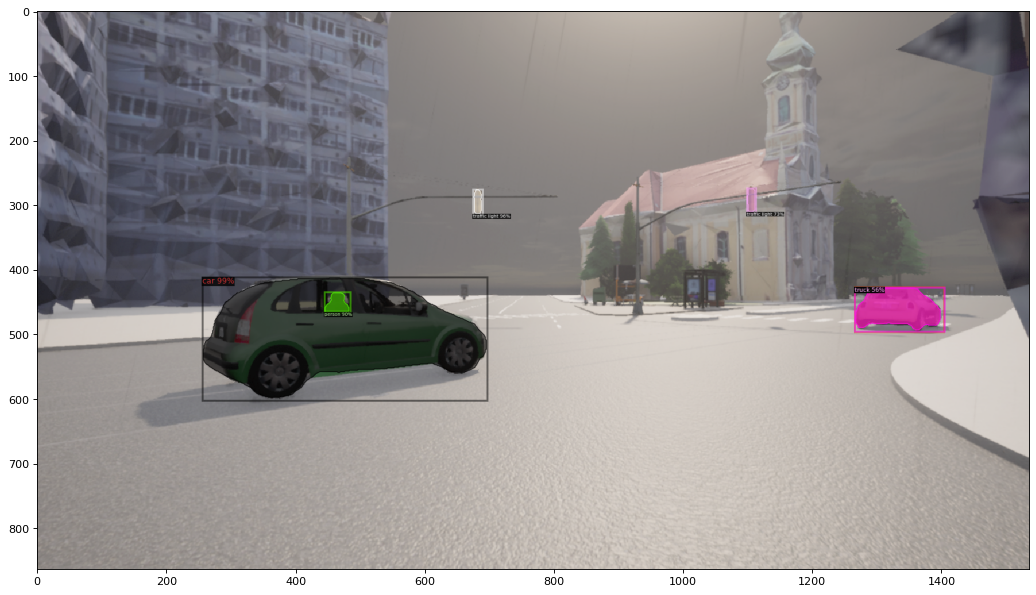

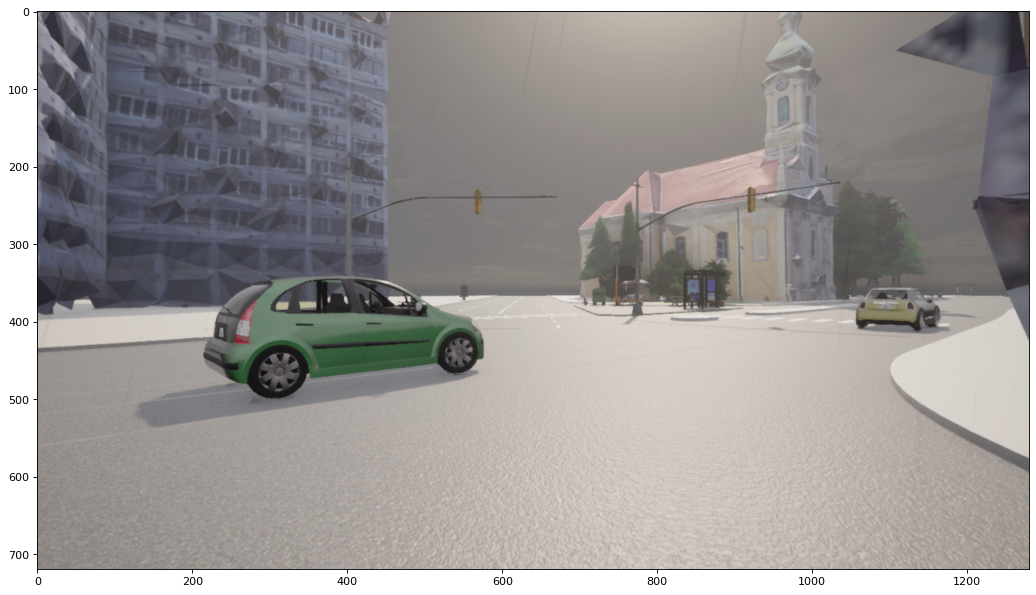

In [65]:
for t in acc:
    img_idx = acc[t].index(0)
    im = cv2.imread(f'{img_dir}/{img_idx:06}.png')[:, :, ::-1]
    gt = cv2.imread(f'{gt_dir}/{img_idx:06}.png')[:, :, ::-1]
    out = predict_instance_segmentation(im[:, :, ::-1], predictor, cfg)
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2_imshow(gt[:, :, ::-1])

In [12]:
from scene_parse.object_detector.datasets import CarlaDataset
from scene_parse.object_detector.models import get_pretrained_mask_rcnn
from scene_parse.object_detector.predictor import get_object_predictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
import os
import random
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

In [7]:
dataset = CarlaDataset()
categories = dataset.get_categories()

In [8]:
DatasetCatalog.register("carla", dataset.dataset_loader('C:/Users/chenp/Documents/github/Clevr-Relational/data/instance-segmentation/rgb', 'C:/Users/chenp/Documents/github/Clevr-Relational/data/instance-segmentation/scenes.json'))
MetadataCatalog.get("carla").set(thing_classes=categories)

loading dataset: 100%|██████████| 200/200 [00:01<00:00, 147.56it/s]


namespace(name='carla', thing_classes=['car'])

loading dataset: 100%|██████████| 200/200 [00:01<00:00, 149.21it/s]


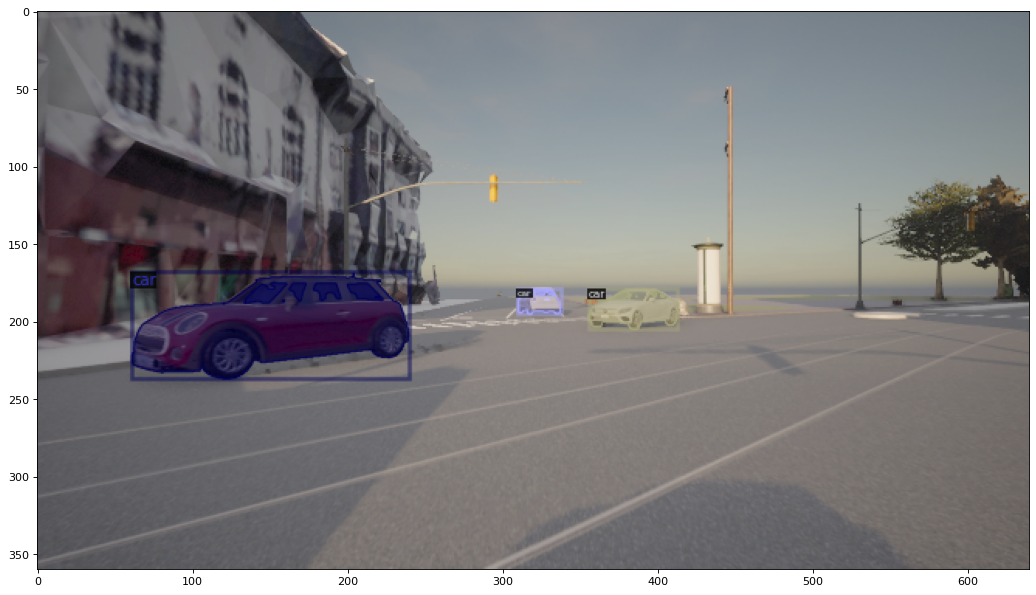

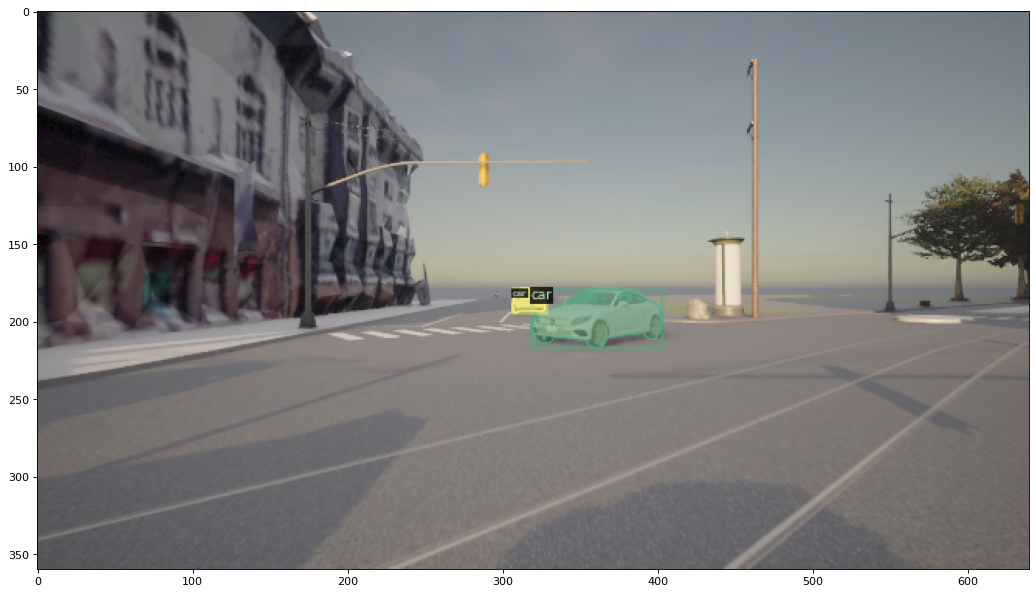

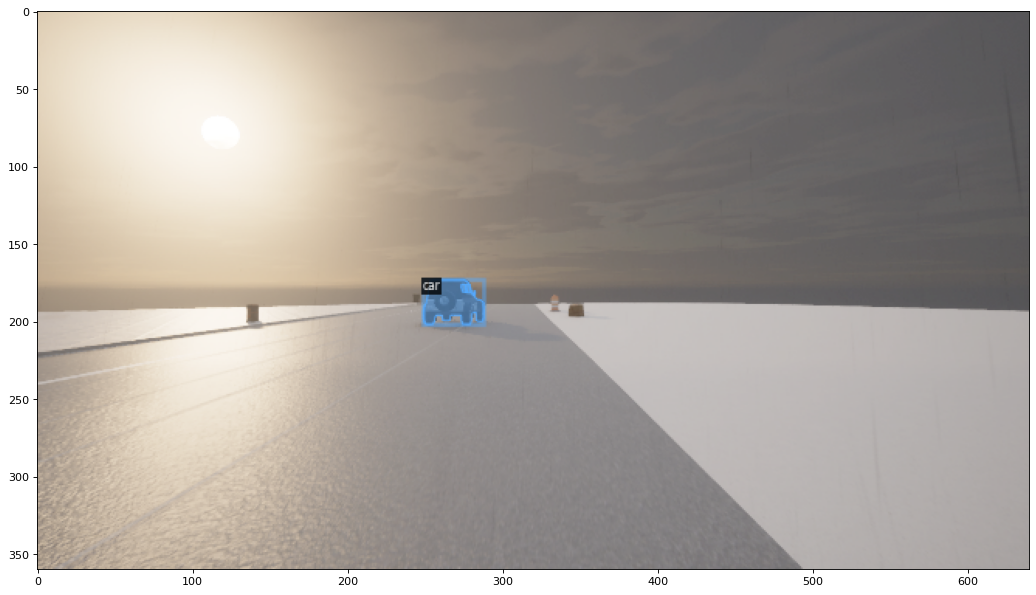

In [16]:
dataset_dicts = dataset.dataset_loader('C:/Users/chenp/Documents/github/Clevr-Relational/data/instance-segmentation/rgb', 'C:/Users/chenp/Documents/github/Clevr-Relational/data/instance-segmentation/scenes.json')()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("carla"), scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [59]:
cfg = get_pretrained_mask_rcnn('carla', len(categories), max_iter=8000)

cfg.OUTPUT_DIR = './data/object_detector_carla/'

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [60]:
predictor = get_object_predictor(cfg, os.path.join('./data/object_detector_carla/', "model_final.pth"), 0.5)

In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
# Remember to remove the clevr_coco_format.json file if the dataset has been changed. e.g. from 1 category to 48 categories

evaluator = COCOEvaluator("carla", output_dir='.')
val_loader = build_detection_test_loader(cfg, "carla")

print(inference_on_dataset(trainer.model, val_loader, evaluator))

Using previously cached COCO format annotations at '.\carla_coco_format.json'. You need to clear the cache file if your dataset has been modified.


NameError: name 'trainer' is not defined

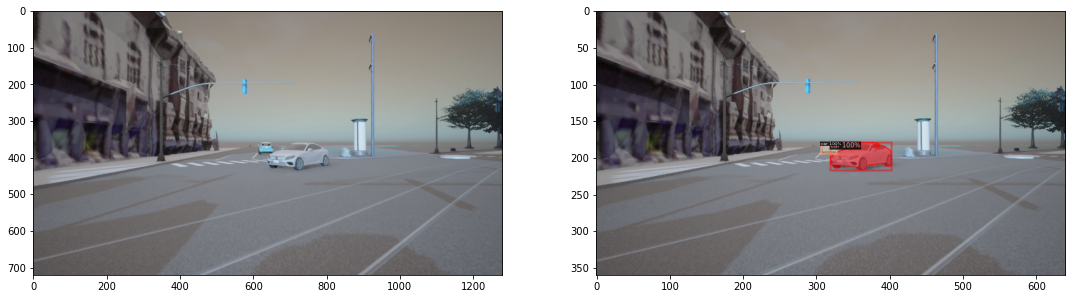

In [61]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d['file_name'])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im,
                   metadata=MetadataCatalog.get('carla'),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(18.5, 10.5)
    ax[0].imshow(im)
    out = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
    ax[1].imshow(out.get_image())


In [58]:
outputs

({'instances': Instances(num_instances=0, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 720, 1280), dtype=torch.bool)])},
 tensor([], device='cuda:0', size=(0, 1024)))

In [93]:
import glob
from tqdm import tqdm
import matplotlib.pyplot as plot
import pycocotools.mask as mask_util
from scripts.utils import get_gtl_transformer

In [116]:
def get_obj_with_type(objects, type_id):
    return [obj for obj in objects if len(obj['semantic_tags']) and obj['semantic_tags'][0] == type_id]

def get_visible_objects(image, objects, type_id, min_pixel):
    type_objects = get_obj_with_type(objects, type_id)
    result = []
    for obj in type_objects:
        color = np.array([type_id, obj['green'], obj['blue']])
        segmentation = (image == color).all(axis=2)

        if segmentation.sum() < min_pixel:
            continue
        mask = mask_util.encode(np.asfortranarray(segmentation))
        obj['mask'] = mask
        result.append(obj)
    return result

def get_camera(objects):
    for obj in objects:
        if obj['type'] == 'camera':
            return obj


def to_local_coord(objects, transformer):
    for obj in objects:
        location = obj['location']
        obj['location'] = list(transformer([location['x'], location['y'], location['z']]))
    return objects

def left_rel(obj1, obj2):
    return obj1[1] < obj2[1]

def right_rel(obj1, obj2):
    return obj1[1] > obj2[1]

def before_rel(obj1, obj2):
    return obj1[0] < obj2[0]

def behind_rel(obj1, obj2):
    return obj1[0] > obj2[0]

REL_MAP = {
    'left': left_rel,
    'right': right_rel,
    'before': before_rel,
    'behind': behind_rel
}

def process_relationships(objects):
    n = len(objects)
    relationships = {rel: [[] for _ in range(n)] for rel in REL_MAP.keys()}

    for i in range(n):
        for j in range(i + 1, n):
            for rel, check in REL_MAP.items():
                if check(objects[i]['location'], objects[j]['location']):
                    relationships[rel][i].append(j)
                if check(objects[j]['location'], objects[i]['location']):
                    relationships[rel][j].append(i)

    return relationships

In [121]:
vehicle_pixels = []
TYPE_IDS = {
    10: 'vehicle',
    4: 'pedestrain',
    18: 'traffic_light'
}

scenes = []
for image_path in tqdm(image_names):
    type_id = 10
    image_name = image_path.split('\\')[-1].split('.')[0]
    image = cv2.imread(image_path)[:, :, ::-1]
    objects = read_json(f'../data/carla/scene_graph/{int(image_name)}.json')
    visible_objects = []
    for type_id in TYPE_IDS:
        visible_objects.extend(get_visible_objects(image, objects, type_id, MIN_PIXEL))

    camera = get_camera(objects)
    transformer = get_gtl_transformer((camera['location']['x'], camera['location']['y'], camera['location']['z']), camera['rotation']['yaw'])
    to_local_coord(visible_objects, transformer)

    relationships = process_relationships(visible_objects)

    scenes.append({
        'objects': visible_objects,
        'image_id': int(image_name),
        'image_filename': f'{image_name}.png',
        'relationships': relationships
    })

100%|██████████| 201/201 [00:51<00:00,  3.92it/s]


In [120]:
scenes[9]

{'objects': [{'id': 117299,
   'green': 51,
   'blue': 202,
   'semantic_tags': [10],
   'type': 'vehicle',
   'location': [172.4598526252533, -34.10952490367298, -1.0041905832476914],
   'rotation': {'pitch': 7.51320767449215e-05,
    'yaw': -109.91706848144531,
    'roll': -3.051757266803179e-05},
   'mask': {'size': [320, 480],
    'counts': b'mVP26i9101OO100001OK[FNg90YF0i90Ueb2'}},
  {'id': 119012,
   'green': 228,
   'blue': 208,
   'semantic_tags': [10],
   'type': 'ambulance',
   'location': [167.8181212071357, -29.738302942877738, -1.0074194190092385],
   'rotation': {'pitch': 0.07594487071037292,
    'yaw': 90.74201965332031,
    'roll': -0.0555114708840847},
   'mask': {'size': [320, 480],
    'counts': b'inS2:f92N0000O1O10000002N00O5GXo]2'}},
  {'id': 119192,
   'green': 152,
   'blue': 209,
   'semantic_tags': [10],
   'type': 'vehicle',
   'location': [182.10087969633477, -56.36092286617397, -1.0074400948360562],
   'rotation': {'pitch': 0.047695208340883255,
    'yaw': -

In [108]:
image_names[2]

'../data/carla/instance_segmentation\\000340.png'

In [70]:
sorted(vehicle_pixels)

[]

In [18]:
vehicles = get_obj_with_type(scene_graph, 10)

In [56]:
len(image)

320

In [57]:
vehicles[0]

{'id': 120092,
 'green': 28,
 'blue': 213,
 'semantic_tags': [10],
 'type': 'vehicle',
 'location': {'x': -94.92752075195312,
  'y': 27.68848419189453,
  'z': 0.0021387862507253885},
 'rotation': {'pitch': -0.0972004160284996,
  'yaw': 4.5476884841918945,
  'roll': 0.0039623877964913845}}

In [32]:
(image == color).all(axis=2)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])